In [1]:
import os
import abc
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

from sklearn import metrics
from tqdm import tqdm

tf.random.set_seed(1234)
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
IMG_DIM = 32

In [7]:
class CNNModel(tf.keras.Model):
    def __init__(self, kernel_size, pool_layer, pool_size):
        super(CNNModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64, 
                                            kernel_size=kernel_size, 
                                            strides=(1,1), 
                                            activation='relu',
                                            input_shape=(IMG_DIM, IMG_DIM, 3))
        self.pool1 = pool_layer(pool_size=pool_size, strides=(2,2))
        self.conv2 = tf.keras.layers.Conv2D(filters=64, 
                                            kernel_size=kernel_size, 
                                            strides=(1,1), 
                                            activation='relu')
        self.pool2 = pool_layer(pool_size=pool_size, strides=(2,2))
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(units=384, activation='relu')
        self.fc2 = tf.keras.layers.Dense(units=192, activation='relu')
        self.fc3 = tf.keras.layers.Dense(units=14, activation='softmax')

    def call(self, inputs):
        if inputs.shape[0] > 1000:
            res = None
            ds = tf.data.Dataset.from_tensor_slices(inputs) 
            ds = ds.batch(batch_size=100)
            for d in ds:
                x = self.call(d)
                if res is None:
                    res = tf.identity(x)
                else:
                    res = tf.concat([res, x], 0)
        else:
            x = self.conv1(inputs)
            x = self.pool1(x)
            x = self.conv2(x)
            x = self.pool2(x)
            x = self.flatten(x)
            x = self.fc1(x)
            x = self.fc2(x)
            res = self.fc3(x)
        return res

    def fit(self, **kwargs):
        self.train_loss = []
        self.train_fscore = []
        self.test_loss = []
        self.test_fscore = []

        train_ds = kwargs['train_ds']
        x_test = kwargs['x_test']
        y_test = kwargs['y_test']
        cost_func = kwargs['cost_func']
        optimizer = kwargs['optimizer']
        learning_rate = kwargs['learning_rate']
        epochs = kwargs['epochs']

        optimizer = optimizer(learning_rate=learning_rate)

        for epoch in tqdm(range(epochs)):
            epoch_loss = []
            epoch_fscore = []

            for x, y in train_ds:
                with tf.GradientTape() as tape:
                    outputs = self.call(x)
                    loss = cost_func(y, outputs)
                    pred = tf.math.argmax(outputs, axis=1).numpy()
                
                grads = tape.gradient(loss, self.trainable_variables)
                optimizer.apply_gradients(zip(grads, self.trainable_variables))
                epoch_loss.append(loss)
                epoch_fscore.append(metrics.f1_score(tf.reshape(y, [-1]).numpy(), pred, average='weighted'))

            self.train_loss.append((sum(epoch_loss) / float(len(epoch_loss))).numpy())
            self.train_fscore.append(sum(epoch_fscore) / float(len(epoch_fscore)))
            self.test_loss.append(cost_func(y_test, self.call(x_test)))
            self.test_fscore.append(metrics.f1_score(list(y_test), self.predict(x_test), average='weighted'))

    def predict(self, x):
        test_ds = tf.data.Dataset.from_tensor_slices(x) 
        test_ds = test_ds.batch(batch_size=100)

        prediction = []
        for i in test_ds:
            res = self.call(i)
            prediction.extend([i.numpy() for i in tf.math.argmax(res, axis=1)])
        return prediction


def save_results(data, name):
    path = f'{os.getcwd()}/results/{name}.json'
    with open(path, 'w') as fout:
        json.dump(data, fout, indent=1)


def read_results(name):
    path = f'{os.getcwd()}/results/{name}.json'
    with open(path, 'r') as file:
        data = json.load(file)
    return data


def reduce_resolution(x_ds, dim = [IMG_DIM, IMG_DIM]):
    x_ds = tf.image.resize(
        x_ds, dim, 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
        preserve_aspect_ratio=False,
        name=None
    )
    x_ds = tf.cast(x_ds, tf.float32) / 255.0
    return x_ds

In [3]:
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [12]:
dataset['train']['X'].shape

(8870, 224, 224, 3)

In [13]:
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

x_train = dataset['train']['X']
x_train = reduce_resolution(x_train)
y_train = dataset['train']['y']

x_test = dataset['test']['X']
x_test = reduce_resolution(x_test)
y_test = dataset['test']['y']

x_vldt = dataset['validation']['X']
x_vldt = reduce_resolution(x_vldt)
y_vldt = dataset['validation']['y']

labels = dataset['labels_mapping']

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) 
train_ds = train_ds.shuffle(buffer_size=len(x_train)).batch(batch_size=100)

In [15]:
optimizer = tf.keras.optimizers.Adam
learning_rate = 0.001
epochs = 15
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
pool_layer = tf.keras.layers.MaxPool2D

model = CNNModel([5,5], pool_layer, [3,3])
model.fit(train_ds=train_ds, x_test=x_vldt, y_test=y_vldt, cost_func=cost_func,
            optimizer=optimizer, learning_rate=learning_rate, epochs=epochs)

100%|██████████| 15/15 [01:24<00:00,  5.64s/it]


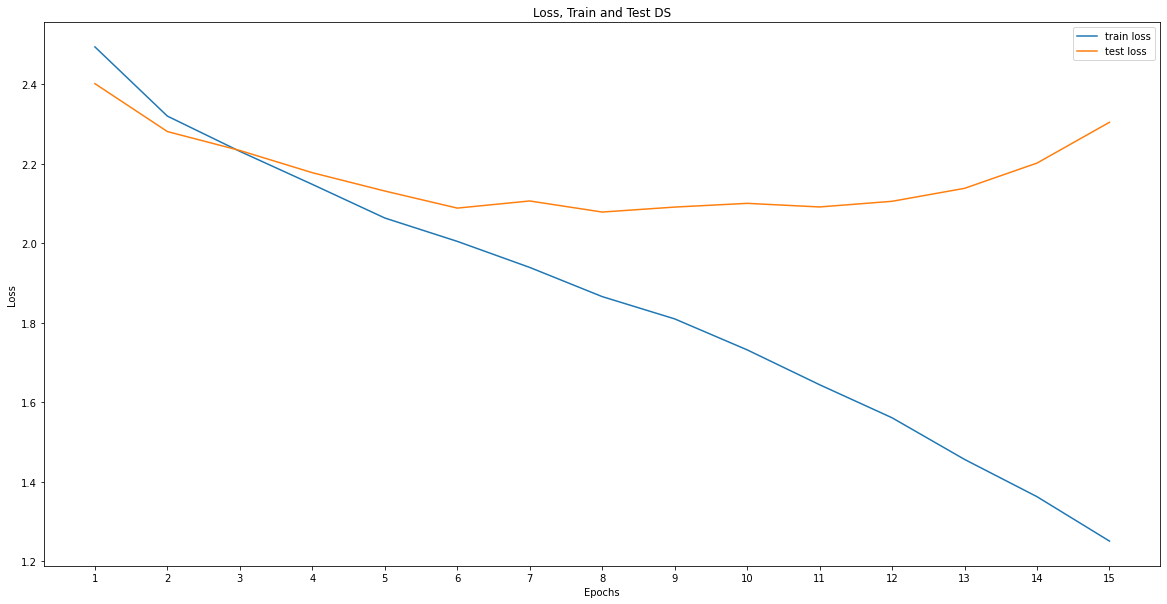

In [16]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes()

plt.title("Loss, Train and Test DS")
plt.xlabel("Epochs")
plt.ylabel("Loss")

x = range(1, len(model.train_loss) + 1)
plt.xticks(np.arange(1, epochs+1))

ax.plot(x, model.train_loss, label='train loss')
ax.plot(x, model.test_loss, label='test loss')

plt.legend()

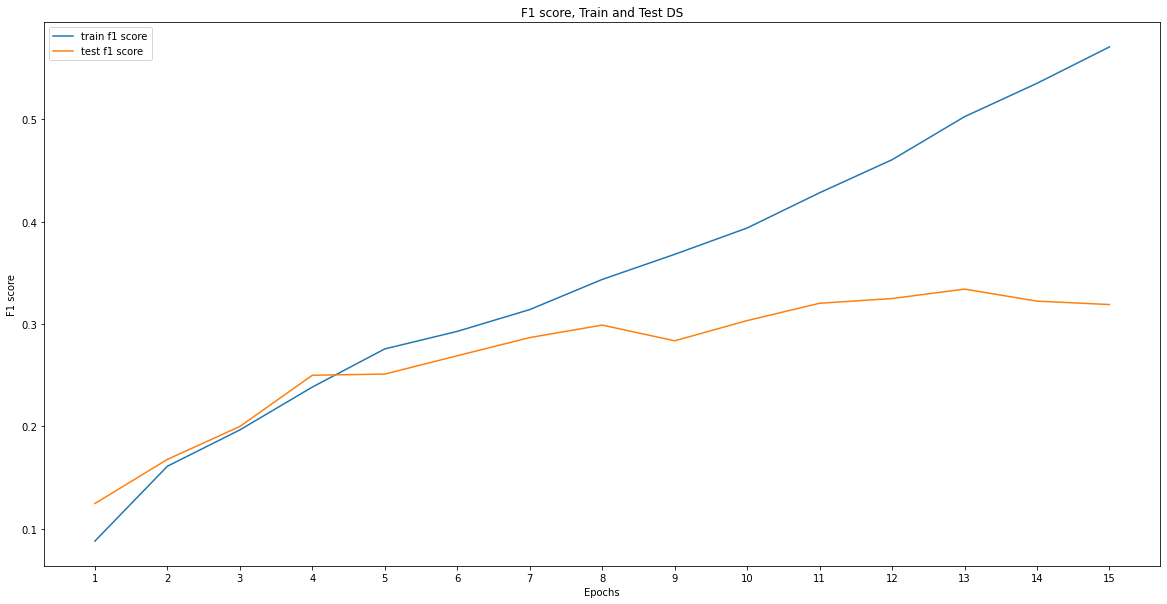

In [17]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes()

plt.title("F1 score, Train and Test DS")
plt.xlabel("Epochs")
plt.ylabel("F1 score");

x = range(1, len(model.train_fscore) + 1)
plt.xticks(np.arange(1, epochs+1))

ax.plot(x, model.train_fscore, label='train f1 score');
ax.plot(x, model.test_fscore, label='test f1 score');

plt.legend()

# Wnioski

Sieć konwolucyjną zaimplementowano według architektury wskazanej w zadaniu. `Funkcję aktywacji RELU przekazano jako paramentr warstwy konwolucyjnej`, nie dodano jej jako kolejnej warstwy sieci.

Sieć wyuczono na zbiorze treningowym z wykorzystaniem następnych paramertów: 
<pre>
- optimizer:        Adam 
- learning rate:    0.001
- cost func:        SparseCategoricalCrossentropy
- pooling layer:    MaxPool2D
- epochs:           15
- batch size:       100
- kernel size:      5x5
- pooling size:     3x3
</pre>

Osiągnięto `wynik miary fscore ~0.3`.
Zauważono, że po 13 epoce straty zaczynają rosnąć, a fscore maleje na zbiorze testowym, kiedy fscore na zbiorze treningowym rośnie i osiąga wartość > 0.5.

In [7]:
kernel_sizes = [[3, 3], [5, 5], [7, 7]]
pool_layers = [tf.keras.layers.MaxPool2D, tf.keras.layers.AveragePooling2D]
pool_sizes = [[2, 2], [3, 3], [4, 4]]
results = []

for k_size in kernel_sizes:
    for p_layer in pool_layers:
        for p_size in pool_sizes:
            model = CNNModel(k_size, p_layer, p_size)
            model.fit(train_ds=train_ds, x_test=x_vldt, y_test=y_vldt, cost_func=cost_func,
                        optimizer=optimizer, learning_rate=learning_rate, epochs=epochs)
            results.append({'kernel_size': k_size, 'pool_layers': p_layer().name, 'pool_size': p_size,
                            'train_loss': [np.float64(i) for i in model.train_loss], 'train_fscore': list(model.train_fscore),
                            'vldt_loss': [np.float64(i.numpy()) for i in model.test_loss], 'vldt_fscore': list(model.test_fscore)})

100%|██████████| 15/15 [01:37<00:00,  6.51s/it]


In [8]:
save_results(results, f'hiper{IMG_DIM}')

In [7]:
res_hiper = read_results(f'hiper{IMG_DIM}')

In [8]:
res = []

for i in res_hiper:
    res.append(i['vldt_fscore'][-1])

top2index = sorted(range(len(res)), key=lambda i: res[i])[-2:]
bottom2index = sorted(range(len(res)), key=lambda i: res[i])[:2]

top2res = [res_hiper[i] for i in top2index]
bottom2res = [res_hiper[i] for i in bottom2index]
res = top2res + bottom2res

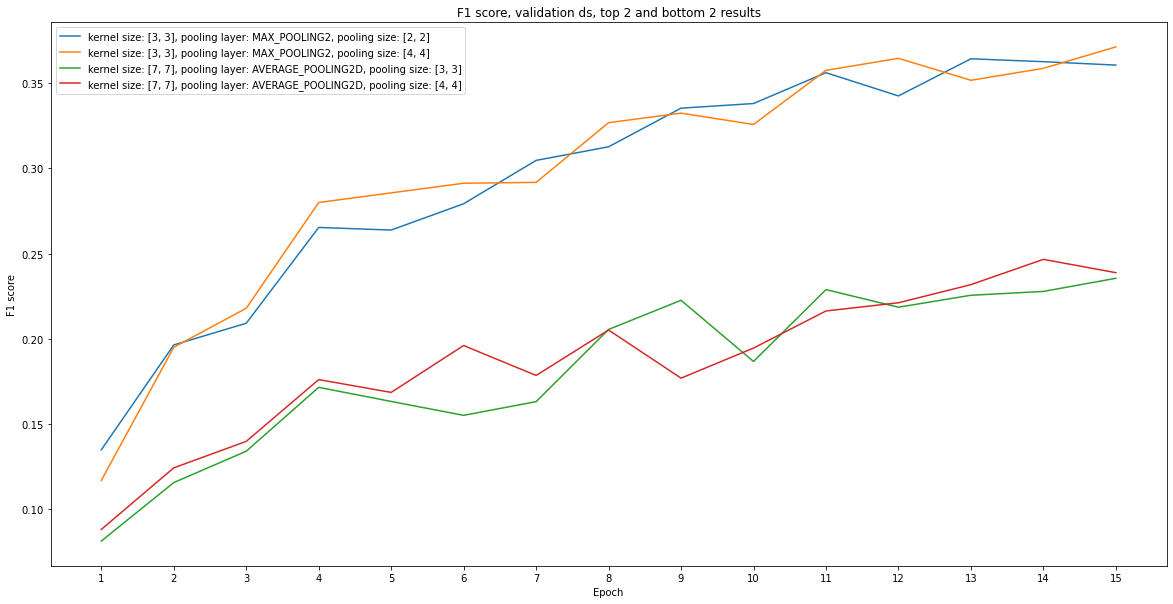

In [9]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes()

plt.title('F1 score, validation ds, top 2 and bottom 2 results')
plt.xlabel('Epoch')
plt.ylabel('F1 score')

x = range(1, epochs+1)
plt.xticks(np.arange(1, epochs+1))

for r in res:
    ax.plot(x, r['vldt_fscore'], label=f'kernel size: {r["kernel_size"]}, pooling layer: {r["pool_layers"][:-3].upper()}, pooling size: {r["pool_size"]}')

plt.legend()

# Wnioski

Do testów wybrano kolejne wartości hiperparametrów:
<pre>
- kernel size:      [3,3], [5,5], [7,7]
- pooling layer:    MaxPooling, AveragePooling
- pooling size:     [2,2], [3,3], [4,4]
</pre>

Wybrano 2 najlepszych i 2 najgorszych modeli spośród 18 i przedstawiono na wykresie wyniki miary fscore dla zbioru walidacyjnego. 
Na wykresie można zauważyć, że zaimplementowana architektura sieci konwolucyjnej pokazuje najlepsze wyniki dla miary `fscore (>0.35)`, kiedy wymiar filtra jest minimalny, a pooling layer - `MaxPool`. Najgorsze wyniki otrzymano przy maksymalnym rozmiarze filtra i AveragePooling. Wyniki różnią się o prawie 15% miary fscore.

Do kolejnych banań wybrano następne parametry:
<pre>
- kernel size:      [3,3]
- pooling layer:    MaxPooling
- pooling size:     [4,4]
</pre>

In [19]:
#BEST HIPERPARAMS
kernel_size = [3,3]
pooling_layer = tf.keras.layers.MaxPool2D
pooling_size = [4,4]

model = CNNModel(kernel_size, pooling_layer, pooling_size)
model.fit(train_ds=train_ds, x_test=x_test, y_test=y_test, cost_func=cost_func,
            optimizer=optimizer, learning_rate=learning_rate, epochs=epochs)

100%|██████████| 15/15 [01:23<00:00,  5.53s/it]


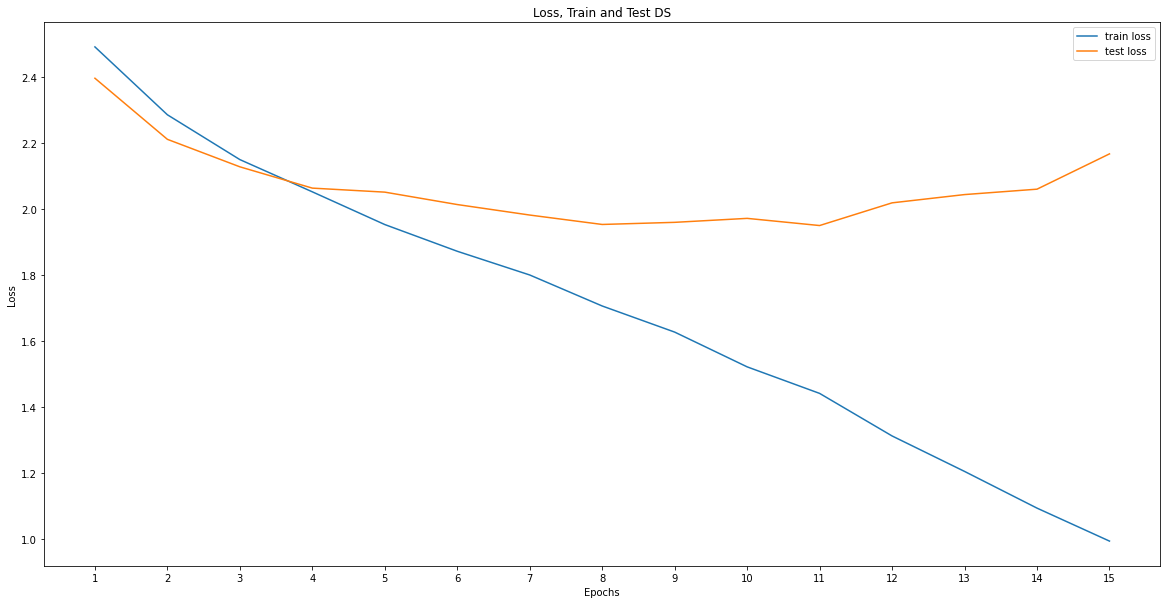

In [20]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes()

plt.title("Loss, Train and Test DS")
plt.xlabel("Epochs")
plt.ylabel("Loss")

x = range(1, len(model.train_loss) + 1)
plt.xticks(np.arange(1, epochs+1))

ax.plot(x, model.train_loss, label='train loss')
ax.plot(x, model.test_loss, label='test loss')

plt.legend()

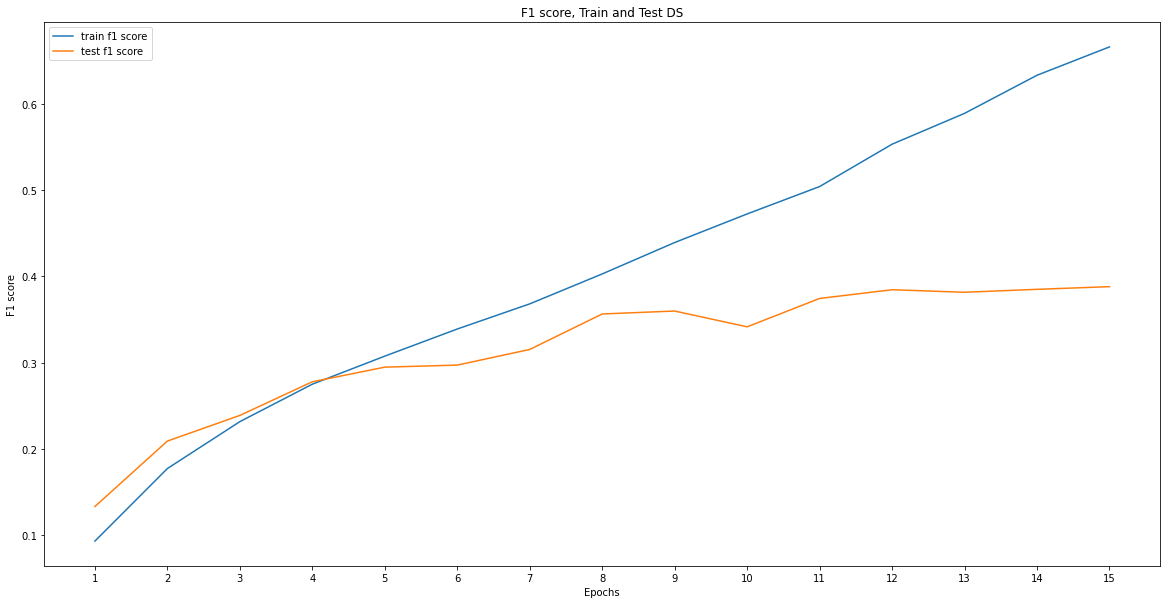

In [21]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes()

plt.title("F1 score, Train and Test DS")
plt.xlabel("Epochs")
plt.ylabel("F1 score");

x = range(1, len(model.train_fscore) + 1)
plt.xticks(np.arange(1, epochs+1))

ax.plot(x, model.train_fscore, label='train f1 score');
ax.plot(x, model.test_fscore, label='test f1 score');

plt.legend()

[Text(0.5, 0, 'indo-islamic'),
 Text(1.5, 0, 'chinese'),
 Text(2.5, 0, 'art_deco'),
 Text(3.5, 0, 'secession'),
 Text(4.5, 0, 'romanesque'),
 Text(5.5, 0, 'byzantine'),
 Text(6.5, 0, 'russian_revival'),
 Text(7.5, 0, 'victorian_quenn_anne'),
 Text(8.5, 0, 'neoclassical'),
 Text(9.5, 0, 'postmodernism'),
 Text(10.5, 0, 'baroque'),
 Text(11.5, 0, 'achaemenid'),
 Text(12.5, 0, 'ancient'),
 Text(13.5, 0, 'renaissance')]

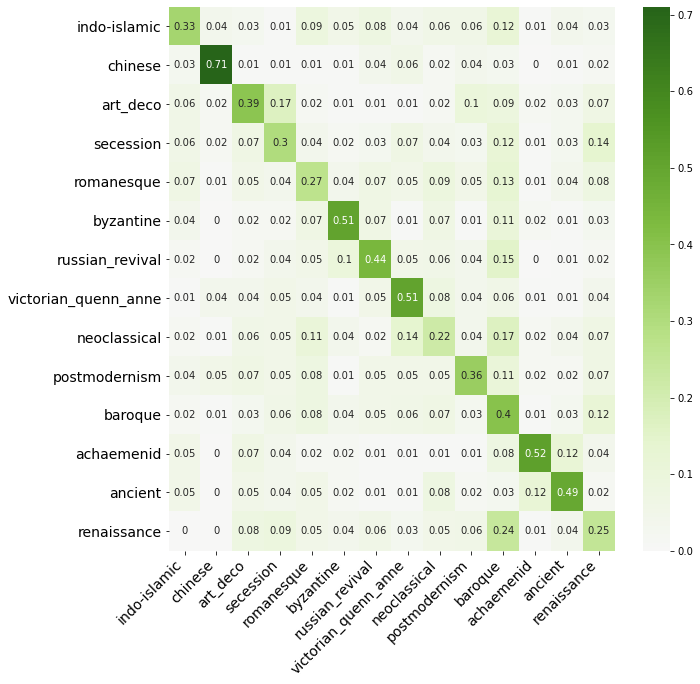

In [22]:
names = list(labels.keys())

test_dataset = (x_test, y_test)
y_pred = model.predict(x_test)
conf_matrix = tf.math.confusion_matrix(y_pred, y_test).numpy()
conf_matrix = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)
fig, ax = plt.subplots(figsize=(10,10))   
ax = sns.heatmap(conf_matrix, cmap="PiYG",
            annot=True, center=0)
ax.yaxis.set_ticklabels(names, rotation=0, ha='right', fontsize=14)
ax.xaxis.set_ticklabels(names, rotation=45, ha='right', fontsize=14)

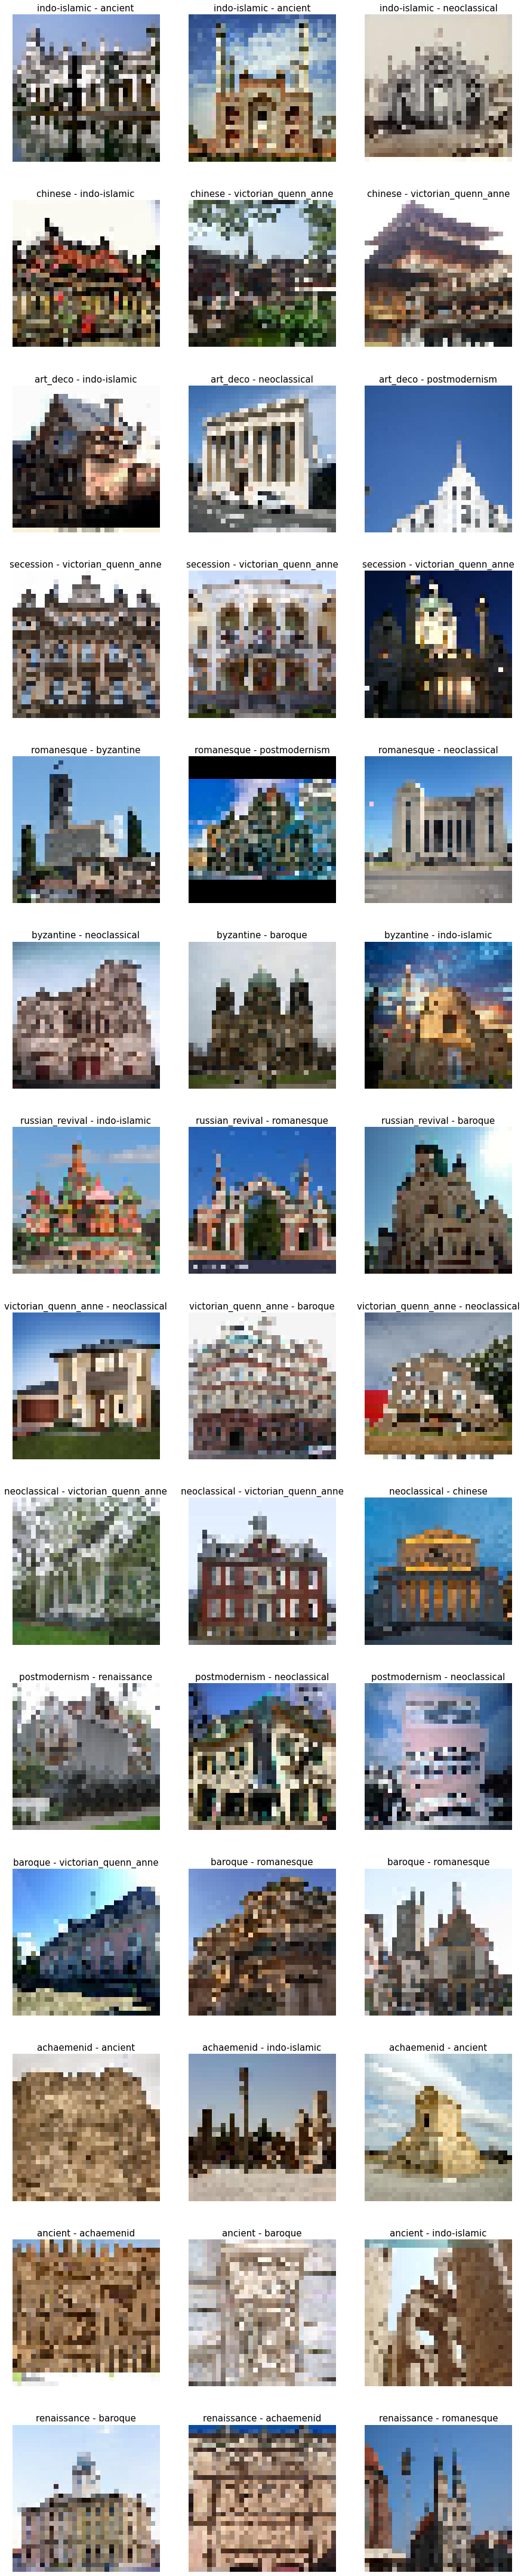

In [40]:
imgs, true_labels, pred_labels = [], [], []
max_exp = 3
# counter = np.zeros(len(labels))

for i in range(len(labels)):
    counter = 0
    for img, true_label, pred_label in zip(x_test, y_test, y_pred):
        if counter == 3: break
        if true_label == i and pred_label != true_label:
            imgs.append(img)
            pred_labels.append(pred_label)
            true_labels.append(true_label)
            counter += 1

fig = plt.figure(figsize=(15,80))
fig.subplots_adjust(wspace=0.2, hspace=0)
for n in range(42):
    ax = plt.subplot(14, 3, n+1)
    plt.imshow(imgs[n])
    title = f'{list(labels.keys())[true_labels[n]]} - {list(labels.keys())[pred_labels[n]]}'
    plt.title(title, fontsize = 15)
    plt.axis('off')

# Wnioski

Na wykresie można zauważyć, że straty sieci zaczynają rosnąć po 10 epoce na zbiorze testowym. Ale to nie wpływa na pozytywne powiększenie miary fscore.
Confusion matrix sieci konolucyjnej wygląda znacznie lepiej od confusion matrix sieci MLP. 

# T O D O

### ~~Zaimplementować sieć koew.~~
- ~~`Wnioski` porównanie f celu i f1 z sicią MLP + funkcja aktywacji relu nie została zaimplementowana jako osobna warstwa, natomiast skonfigurowano ją w warstwie konwolucyjnej~~
---
### ~~Min 4 konfiguracje: *dobierając odpowiedni rozmiar filtra i pool layer (+ pool size)*~~
- ~~f1 dla każdego modelu: *min jeden z nich f1 >= 0.35 na* **zbiorze walidacyjnym**~~
- ~~`Wnioski` porównać modele~~
---
### ~~Ewaluacja najlepszej konfiguracji *na zbiorze testowym*~~
- ~~f1 w zależności od numeru epoki~~
- ~~f kosztu w zależności od numeru epoki~~
- ~~confusion matrix: **co to??**~~
- ~~wizualizację kilku przykładów na klasę, dla których model podejmowal złą decyzję (przeanalizuj dlaczego model mógł źle sklasyfikować*)~~
- ~~`Wnioski`~~